In [3]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime as dt
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 
from matplotlib.colors import LogNorm

### Functions

In [4]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [5]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [6]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [7]:
#Import ros2south data
#Dec 15th 2017 - Dec 27th 2021
rostosouth_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/rostosouth17-21.csv')
datelist_rostosouth = pd.to_datetime(rostosouth_df['Date'])
rostosouth = pd.DataFrame({'Transport':rostosouth_df['Transport'].values},index=datelist_rostosouth)['Transport']

#Only 2017
rostosouth_2017_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/rostosouth_2017.csv')
datelist_rostosouth_2017 = pd.to_datetime(rostosouth_2017_df['Date'])
rostosouth_2017 = pd.DataFrame({'Transport':rostosouth_2017_df['Transport'].values},index=datelist_rostosouth_2017)['Transport']
rostosouth_2017

#Only 2018
#Dec 16th 2017 - Dec 29th 2018
rostosouth_2018_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/rostosouth_2018.csv')
datelist_rostosouth_2018 = pd.to_datetime(rostosouth_2018_df['Date'])
rostosouth_2018 = pd.DataFrame({'Transport':rostosouth_2018_df['Transport'].values},index=datelist_rostosouth_2018)['Transport']
rostosouth_2018

#Only 2019
#Jan 10th 2019 - Dec 29th 2019
rostosouth_2019_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/rostosouth_2019.csv')
datelist_rostosouth_2019 = pd.to_datetime(rostosouth_2019_df['Date'])
rostosouth_2019 = pd.DataFrame({'Transport':rostosouth_2019_df['Transport'].values},index=datelist_rostosouth_2019)['Transport']
rostosouth_2019

#Only 2020
#Jan 5th 2020 - Dec 13th 2020
rostosouth_2020_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/rostosouth_2020.csv')
datelist_rostosouth_2020 = pd.to_datetime(rostosouth_2020_df['Date'])
rostosouth_2020 = pd.DataFrame({'Transport':rostosouth_2020_df['Transport'].values},index=datelist_rostosouth_2020)['Transport']
rostosouth_2020

#Only 2021
#Dec18th 2020 - Dec 27th 2021
rostosouth_2021_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/rostosouth_2021.csv')
datelist_rostosouth_2021 = pd.to_datetime(rostosouth_2021_df['Date'])
rostosouth_2021 = pd.DataFrame({'Transport':rostosouth_2021_df['Transport'].values},index=datelist_rostosouth_2021)['Transport']

## PRtovs

#Dec 15th 2017 - Dec 27th 2021
prtovs_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs_ros_avg.csv')
datelist_prtovs_ros_avg = pd.to_datetime(prtovs_ros_avg_df['Date'])
prtovs_ros_avg = pd.DataFrame({'Transport':prtovs_ros_avg_df['Transport'].values},index=datelist_prtovs_ros_avg)['Transport']

#Only 2017
#Dec 16th 2017 - Dec 29th 2018
PRtovs2017_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2017_ros_avg.csv')
datelist_prtovs_2017 = pd.to_datetime(PRtovs2017_ros_avg_df['Date'])
PRtovs2017_ros_avg = pd.DataFrame({'Transport':PRtovs2017_ros_avg_df['Transport'].values},index=datelist_prtovs_2017)['Transport']
PRtovs2017_ros_avg_df

#Only 2018
#Dec 16th 2017 - Dec 29th 2018
PRtovs2018_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2018_ros_avg.csv')
datelist_prtovs_2018 = pd.to_datetime(PRtovs2018_ros_avg_df['Date'])
PRtovs2018_ros_avg = pd.DataFrame({'Transport':PRtovs2018_ros_avg_df['Transport'].values},index=datelist_prtovs_2018)['Transport']
PRtovs2018_ros_avg_df

#Only 2019
#Jan 9th 2019 - Dec 29th 2019
PRtovs2019_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2019_ros_avg.csv')
datelist_prtovs_2019 = pd.to_datetime(PRtovs2019_ros_avg_df['Date'])
PRtovs2019_ros_avg = pd.DataFrame({'Transport':PRtovs2019_ros_avg_df['Transport'].values},index=datelist_prtovs_2019)['Transport']
PRtovs2019_ros_avg_df

#Only 2020
#Jan 5th 2020 - Dec 13th 2020
PRtovs2020_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2020_ros_avg.csv')
datelist_prtovs_2020 = pd.to_datetime(PRtovs2020_ros_avg_df['Date'])
PRtovs2020_ros_avg = pd.DataFrame({'Transport':PRtovs2020_ros_avg_df['Transport'].values},index=datelist_prtovs_2020)['Transport']
PRtovs2020_ros_avg_df

#Only 2021
#Dec18th 2020 - Dec 27th 2021
PRtovs2021_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2021_ros_avg.csv')
datelist_prtovs_2021 = pd.to_datetime(PRtovs2021_ros_avg_df['Date'])
PRtovs2021_ros_avg = pd.DataFrame({'Transport':PRtovs2021_ros_avg_df['Transport'].values},index=datelist_prtovs_2021)['Transport']
PRtovs2021_ros_avg_df

## PRtoadm

#Dec 14th 2017 - Dec 27th 2021
prtoadm_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoadm_ros_avg.csv')
datelist_prtoadm_ros_avg = pd.to_datetime(prtoadm_ros_avg_df['Date'])
prtoadm_ros_avg = pd.DataFrame({'Transport':prtoadm_ros_avg_df['Transport'].values},index=datelist_prtoadm_ros_avg)['Transport']

#Only 2017
#Dec 13th 2017 - Dec 29th 2018
PRtoadm2017_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoadm2017_ros_avg.csv')
datelist_prtoadm_2017 = pd.to_datetime(PRtoadm2017_ros_avg_df['Date'])
PRtoadm2017_ros_avg = pd.DataFrame({'Transport':PRtoadm2017_ros_avg_df['Transport'].values},index=datelist_prtoadm_2017)['Transport']
PRtoadm2017_ros_avg_df

#Only 2018
#Dec 13th 2017 - Dec 29th 2018
PRtoadm2018_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoadm2018_ros_avg.csv')
datelist_prtoadm_2018 = pd.to_datetime(PRtoadm2018_ros_avg_df['Date'])
PRtoadm2018_ros_avg = pd.DataFrame({'Transport':PRtoadm2018_ros_avg_df['Transport'].values},index=datelist_prtoadm_2018)['Transport']
PRtoadm2018_ros_avg_df

#Only 2019
#Jan 10th 2019 - Dec 29th 2019
PRtoadm2019_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoadm2019_ros_avg.csv')
datelist_prtoadm_2019 = pd.to_datetime(PRtoadm2019_ros_avg_df['Date'])
PRtoadm2019_ros_avg = pd.DataFrame({'Transport':PRtoadm2019_ros_avg_df['Transport'].values},index=datelist_prtoadm_2019)['Transport']
PRtoadm2019_ros_avg_df

#Only 2020
#Jan 3th 2020 - Dec 13th 2020
PRtoadm2020_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoadm2020_ros_avg.csv')
datelist_prtoadm_2020 = pd.to_datetime(PRtoadm2020_ros_avg_df['Date'])
PRtoadm2020_ros_avg = pd.DataFrame({'Transport':PRtoadm2020_ros_avg_df['Transport'].values},index=datelist_prtoadm_2020)['Transport']
PRtoadm2020_ros_avg_df

#Only 2021
#Dec17th 2020 - Dec 27th 2021
PRtoadm2021_ros_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoadm2021_ros_avg.csv')
datelist_prtoadm_2021 = pd.to_datetime(PRtoadm2021_ros_avg_df['Date'])
PRtoadm2021_ros_avg = pd.DataFrame({'Transport':PRtoadm2021_ros_avg_df['Transport'].values},index=datelist_prtoadm_2021)['Transport']
rostosouth_2018

# Import Haro data

## PR to VS

# Full
prtovs_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs18_21_haro_avg.csv')
datelist_prtovs_haro_avg = pd.to_datetime(prtovs_haro_avg_df['Date'])
prtovs_haro_avg = pd.DataFrame({'Transport':prtovs_haro_avg_df['Transport'].values},index=datelist_prtovs_haro_avg)['Transport']

# #Only 2017
PRtovs2017_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2017_haro_avg.csv')
datelist_prtovs_haro2017 = pd.to_datetime(PRtovs2017_haro_avg_df['Date'])
PRtovs2017_haro_avg = pd.DataFrame({'Transport':PRtovs2017_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2017)['Transport']

# #Only 2018
PRtovs2018_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2018_haro_avg.csv')
datelist_prtovs_haro2018 = pd.to_datetime(PRtovs2018_haro_avg_df['Date'])
PRtovs2018_haro_avg = pd.DataFrame({'Transport':PRtovs2018_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2018)['Transport']

# #Only 2019
PRtovs2019_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2019_haro_avg.csv')
datelist_prtovs_haro2019 = pd.to_datetime(PRtovs2019_haro_avg_df['Date'])
PRtovs2019_haro_avg = pd.DataFrame({'Transport':PRtovs2019_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2019)['Transport']

# #Only 2020
PRtovs2020_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2020_haro_avg.csv')
datelist_prtovs_haro2020 = pd.to_datetime(PRtovs2020_haro_avg_df['Date'])
PRtovs2020_haro_avg = pd.DataFrame({'Transport':PRtovs2020_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2020)['Transport']

# #Only 202q
PRtovs2021_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2021_haro_avg.csv')
datelist_prtovs_haro2021 = pd.to_datetime(PRtovs2021_haro_avg_df['Date'])
PRtovs2021_haro_avg = pd.DataFrame({'Transport':PRtovs2021_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2021)['Transport']

# #Only 2021
# PRtovs2021_haro_avg_df = pd.read_csv('combined2timeseries/PRtovs2021_haro_avg.csv')
# datelist_prtovs_haro2021 = pd.to_datetime(PRtovs2021_haro_avg_df['Date'])
# PRtovs2021_haro_avg = pd.DataFrame({'Transport':PRtovs2021_haro_avg_df['Transport'].values},index=datelist_prtovs_haro2021)['Transport']

## Gulf to VS

# Full
Gulftovs_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs18_21_haro_avg.csv')
datelist_Gulftovs_haro_avg = pd.to_datetime(Gulftovs_haro_avg_df['Date'])
Gulftovs_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_avg)['Transport']

# #Only 2017
# Gulftovs2017_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2017_haro_avg.csv')
# datelist_Gulftovs_haro_2017 = pd.to_datetime(Gulftovs2017_haro_avg_df['Date'])
# Gulftovs2017_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2017)['Transport']

# # #Only 2018
Gulftovs2018_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2018_haro_avg.csv')
datelist_Gulftovs_haro_2018 = pd.to_datetime(Gulftovs2018_haro_avg_df['Date'])
Gulftovs2018_haro_avg = pd.DataFrame({'Transport':Gulftovs2018_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2018)['Transport']

# # #Only 2019
Gulftovs2019_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2019_haro_avg.csv')
datelist_Gulftovs_haro_2019 = pd.to_datetime(Gulftovs2019_haro_avg_df['Date'])
Gulftovs2019_haro_avg = pd.DataFrame({'Transport':Gulftovs2019_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2019)['Transport']

# # #Only 2020
Gulftovs2020_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2020_haro_avg.csv')
datelist_Gulftovs_haro_2020 = pd.to_datetime(Gulftovs2020_haro_avg_df['Date'])
Gulftovs2020_haro_avg = pd.DataFrame({'Transport':Gulftovs2020_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2020)['Transport']

# # #Only 2021
Gulftovs2021_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/Gulftovs2021_haro_avg.csv')
datelist_Gulftovs_haro_2021 = pd.to_datetime(Gulftovs2021_haro_avg_df['Date'])
Gulftovs2021_haro_avg = pd.DataFrame({'Transport':Gulftovs2021_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2021)['Transport']

# Vs to PR

# Full
VStoPR_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR18_21_haro_avg.csv')
datelist_VStoPR_haro_avg = pd.to_datetime(VStoPR_haro_avg_df['Date'])
VStoPR_haro_avg = pd.DataFrame({'Transport':VStoPR_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_avg)['Transport']

# #Only 2017
# Gulftovs2017_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2017_haro_avg.csv')
# datelist_Gulftovs_haro_2017 = pd.to_datetime(Gulftovs2017_haro_avg_df['Date'])
# Gulftovs2017_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2017)['Transport']

# # #Only 2018
VStoPR2018_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2018_haro_avg.csv')
datelist_VStoPR_haro_2018 = pd.to_datetime(VStoPR2018_haro_avg_df['Date'])
VStoPR2018_haro_avg = pd.DataFrame({'Transport':VStoPR2018_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2018)['Transport']

# # #Only 2019
VStoPR2019_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2019_haro_avg.csv')
datelist_VStoPR_haro_2019 = pd.to_datetime(VStoPR2019_haro_avg_df['Date'])
VStoPR2019_haro_avg = pd.DataFrame({'Transport':VStoPR2019_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2019)['Transport']

# # #Only 2020
VStoPR2020_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2020_haro_avg.csv')
datelist_VStoPR_haro_2020 = pd.to_datetime(VStoPR2020_haro_avg_df['Date'])
VStoPR2020_haro_avg = pd.DataFrame({'Transport':VStoPR2020_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2020)['Transport']

# # #Only 2021
VStoPR2021_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStoPR2021_haro_avg.csv')
datelist_VStoPR_haro_2021 = pd.to_datetime(VStoPR2021_haro_avg_df['Date'])
VStoPR2021_haro_avg = pd.DataFrame({'Transport':VStoPR2021_haro_avg_df['Transport'].values},index=datelist_VStoPR_haro_2021)['Transport']

# VS to Gulf

# Full
VStogulf_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf18_21_haro_avg.csv')
datelist_VStogulf_haro_avg = pd.to_datetime(VStogulf_haro_avg_df['Date'])
VStogulf_haro_avg = pd.DataFrame({'Transport':VStogulf_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_avg)['Transport']

# #Only 2017
# Gulftovs2017_haro_avg_df = pd.read_csv('combined2timeseries/Gulftovs2017_haro_avg.csv')
# datelist_Gulftovs_haro_2017 = pd.to_datetime(Gulftovs2017_haro_avg_df['Date'])
# Gulftovs2017_haro_avg = pd.DataFrame({'Transport':Gulftovs_haro_avg_df['Transport'].values},index=datelist_Gulftovs_haro_2017)['Transport']

# # #Only 2018
VStogulf2018_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2018_haro_avg.csv')
datelist_VStogulf_haro_2018 = pd.to_datetime(VStogulf2018_haro_avg_df['Date'])
VStogulf2018_haro_avg = pd.DataFrame({'Transport':VStogulf2018_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2018)['Transport']

# # #Only 2019
VStogulf2019_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2019_haro_avg.csv')
datelist_VStogulf_haro_2019 = pd.to_datetime(VStogulf2019_haro_avg_df['Date'])
VStogulf2019_haro_avg = pd.DataFrame({'Transport':VStogulf2019_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2019)['Transport']

# # #Only 2020
VStogulf2020_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2020_haro_avg.csv')
datelist_VStogulf_haro_2020 = pd.to_datetime(VStogulf2020_haro_avg_df['Date'])
VStogulf2020_haro_avg = pd.DataFrame({'Transport':VStogulf2020_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2020)['Transport']

# # #Only 2021
VStogulf2021_haro_avg_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/VStogulf2021_haro_avg.csv')
datelist_VStogulf_haro_2021 = pd.to_datetime(VStogulf2021_haro_avg_df['Date'])
VStogulf2021_haro_avg = pd.DataFrame({'Transport':VStogulf2021_haro_avg_df['Transport'].values},index=datelist_VStogulf_haro_2021)['Transport']

#Only 2018
sjctosouth_2018_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2018_sjc_avg.csv')
datelist_sjctosouth_2018 = pd.to_datetime(sjctosouth_2018_df['Date'])
sjctosouth_2018 = pd.DataFrame({'Transport':sjctosouth_2018_df['Transport'].values},index=datelist_sjctosouth_2018)['Transport']
sjctosouth_2018

#Only 2019
sjctosouth_2019_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2019_sjc_avg.csv')
datelist_sjctosouth_2019 = pd.to_datetime(sjctosouth_2019_df['Date'])
sjctosouth_2019 = pd.DataFrame({'Transport':sjctosouth_2019_df['Transport'].values},index=datelist_sjctosouth_2019)['Transport']
sjctosouth_2019

#Only 2020
sjctosouth_2020_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2020_sjc_avg.csv')
datelist_sjctosouth_2020 = pd.to_datetime(sjctosouth_2020_df['Date'])
sjctosouth_2020 = pd.DataFrame({'Transport':sjctosouth_2020_df['Transport'].values},index=datelist_sjctosouth_2020)['Transport']
sjctosouth_2020

#Only 2021
sjctosouth_2021_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtovs2021_sjc_avg.csv')
datelist_sjctosouth_2021 = pd.to_datetime(sjctosouth_2021_df['Date'])
sjctosouth_2021 = pd.DataFrame({'Transport':sjctosouth_2021_df['Transport'].values},index=datelist_sjctosouth_2021)['Transport']
sjctosouth_2021

#2018-21
sjctosouth_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/combined2timeseries/PRtoVS_sjc_avg.csv')
datelist_sjctosouth = pd.to_datetime(sjctosouth_df['Date'])
sjctosouth = pd.DataFrame({'Transport':sjctosouth_df['Transport'].values},index=datelist_sjctosouth)['Transport']
sjctosouth

Date
2017-12-16    608.113976
2017-12-17    643.219048
2017-12-18    689.088780
2017-12-19    623.746552
2017-12-20    791.231496
                 ...    
2021-12-23    752.208204
2021-12-24    801.520026
2021-12-25    854.447160
2021-12-26    871.266741
2021-12-27    818.837967
Name: Transport, Length: 1472, dtype: float64

### Import density data

In [8]:
# Importing density and tidal data

density_vspr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_vspr_v4.csv')
dens_diff_vspr = np.array(density_vspr.north - density_vspr.south)

density_adm = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2016-22_rosarioNS.csv')
dens_diff_adm = np.array(density_adm.south - density_adm.north)

dens_rospr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_rospr.csv')
dens_haropr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_haropr.csv')

tides_1d = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/day_avg_tide_BP_16-22.csv')
tides = tides_1d['vozocrtx'].rolling(4, center=True).mean()
# tides_ros = pd.read_csv('low_pass_tide_18-22.csv')

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length
 
date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
print(len(datelist_dens))
print(len(dens_diff_vspr))   

2557
2557


#### Winds

In [9]:
wind = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/day_avg_wind_16-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

print(len(y_mean4),len(datelist_winds))

2557 2557


### Fraser river discharge

In [10]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge_16-22.csv')
FR_4mean = FR_data['Discharge (m3/s)'].rolling(window=4,center=True).mean()

date = dt.datetime(2016,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_FR = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_FR.append(date)
    date += dt.timedelta(days=1)

In [11]:
pugetr_df = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/puget_rivers_avg.csv')
datelist_pugetr = pd.to_datetime(pugetr_df['Date'])
pugetr = pd.DataFrame({'discharge(kg/m2/s)':pugetr_df['0'].values},index=datelist_pugetr)['discharge(kg/m2/s)'].rolling(window=4,center=True).mean().dropna()
datelist_pugetr = pd.to_datetime(pugetr.index)
date_pugetr = [pd.to_datetime(date).tz_localize(None).to_pydatetime() for date in datelist_pugetr]

pugetr_m3s = pugetr/1026*500*440

### Through Rosario

In [12]:
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_vspr[mask]
date_dens_sh = np.array(datelist_dens)[mask]

In [13]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

### Through Haro

In [14]:
harotosouth = prtovs_haro_avg + Gulftovs_haro_avg
date_harosh = list(harotosouth.dropna().index)

#### Correlations with transport south through Haro

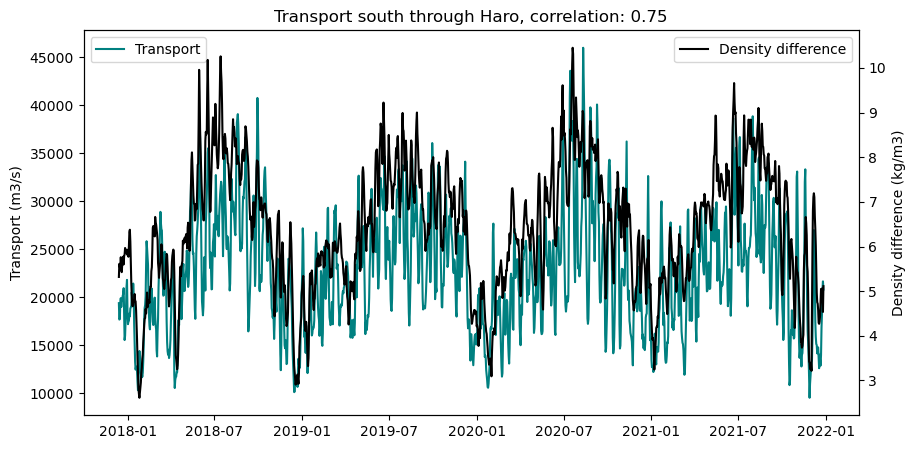

In [15]:
date_harosh = list(harotosouth.dropna().index)

mask = np.isin(datelist_dens,date_harosh)
densdiff_haro = dens_diff_vspr[mask]
date_dens_haro_sh = np.array(datelist_dens)[mask]

corr_harotosouth,p = stats.spearmanr(densdiff_haro,harotosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_haro_sh,densdiff_haro,color='k',label='Density difference')
ax.set_title(f'Transport south through Haro, correlation: {np.round(corr_harotosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

In [16]:
slope,intercept = np.polyfit(densdiff_haro,harotosouth.dropna(),1)
ddline_haro = slope*densdiff_haro+intercept
res_haro = harotosouth.dropna() - ddline_haro

mask = np.isin(datelist_tides,date_harosh)
date_tides_haro_sh = np.array(datelist_tides)[mask]
tides_haro_sh = tides[mask]

corr_res_haro,p = stats.spearmanr(tides_haro_sh[0:385],res_haro[0:385])

### North through Haro

#### VicSill to Point Rob

In [17]:
date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,28)

datelist_forvs_haro = []

while date <= enddate:
    datelist_forvs_haro.append(date)
    date+=dt.timedelta(days=1)
    
datelist_forvs_haro.pop(506)

datetime.datetime(2019, 4, 30, 0, 0)

Text(0, 0.5, 'Transport (m3/s)')

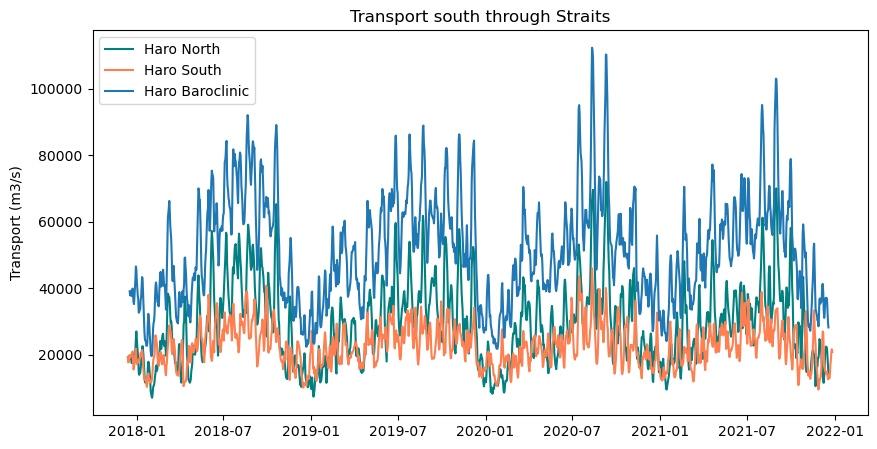

In [18]:
harotonorth = VStogulf_haro_avg + VStoPR_haro_avg
date_haroNsh = list(harotonorth.dropna().index)
haro_bclin = (harotosouth.dropna()+harotonorth.dropna()).dropna()
date_haro_bclin = list(haro_bclin.index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotonorth.dropna(),label='Haro North',color='teal')
ax.plot(harotosouth.dropna(),label='Haro South',color='coral')
ax.plot(haro_bclin.dropna(),label='Haro Baroclinic')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

In [19]:
mask = np.isin(datelist_FR,date_haro_bclin)
FR_haro_bclin = FR_4mean[mask]

#### Look at baroclinic / barotropic separate for the years

In [20]:
haro_btrop = (harotonorth-harotosouth).dropna()
# haro_btrop = (-harotonorth+harotosouth).dropna()
date_haro_btrop = list(haro_bclin.index)

mask = np.isin(datelist_dens,date_haro_btrop)
densdiff_haro_btrop = dens_diff_vspr[mask]
date_DD_haro_btrop = np.array(datelist_dens)[mask]

corr_DD_haro_btrop,p = stats.spearmanr(haro_btrop,densdiff_haro_btrop)
print(corr_DD_haro_btrop)

mask = np.isin(datelist_tides,date_haro_btrop)
tides_haro_btrop = tides[mask]
date_tides_haro_btrop = np.array(datelist_tides)[mask]

corr_tides_haro_btrop,p = stats.spearmanr(tides_haro_btrop,haro_btrop)
print(corr_tides_haro_btrop)

mask = np.isin(datelist_winds,date_haro_btrop)
winds_harobtrop = y_mean4[mask]

slope,intercept = np.polyfit(np.abs(winds_harobtrop),haro_btrop,1)
wline_harobtrop = slope*np.abs(winds_harobtrop)+intercept
wline_harobtrop_plot = slope*np.arange(0,8,0.5) + intercept

corr_btrop_tides,p = stats.spearmanr(tides_haro_btrop,haro_btrop)
print(corr_btrop_tides)

corr_btrop_dd,p = stats.spearmanr(densdiff_haro_btrop,haro_btrop.dropna())
print(corr_btrop_dd)

0.23522055468435968
-0.41124052187058774
-0.41124052187058774
0.23522055468435968


In [21]:
## Calculate haro south, haro north,haro bclin, haro btrop for each

harotosouth_2018 = PRtovs2018_haro_avg.dropna() + Gulftovs2018_haro_avg.dropna()
harotosouth_2019 = PRtovs2019_haro_avg.dropna() + Gulftovs2019_haro_avg.dropna()
harotosouth_2020 = PRtovs2020_haro_avg.dropna() + Gulftovs2020_haro_avg.dropna()
harotosouth_2021 = PRtovs2021_haro_avg.dropna() + Gulftovs2021_haro_avg.dropna()

harotonorth_2018 = VStogulf2018_haro_avg.dropna() + VStoPR2018_haro_avg.dropna()
harotonorth_2019 = VStogulf2019_haro_avg.dropna() + VStoPR2019_haro_avg.dropna()
harotonorth_2020 = VStogulf2020_haro_avg.dropna() + VStoPR2020_haro_avg.dropna()
harotonorth_2021 = VStogulf2021_haro_avg.dropna() + VStoPR2021_haro_avg.dropna()

haro_bclin2018 = (harotosouth_2018 + harotonorth_2018).dropna()
haro_bclin2019 = (harotosouth_2019 + harotonorth_2019).dropna()
haro_bclin2020 = (harotosouth_2020 + harotonorth_2020).dropna()
haro_bclin2021 = (harotosouth_2021 + harotonorth_2021).dropna()

haro_btrop2018 = (-harotosouth_2018 + harotonorth_2018).dropna()
haro_btrop2019 = (-harotosouth_2019 + harotonorth_2019).dropna()
haro_btrop2020 = (-harotosouth_2020 + harotonorth_2020).dropna()
haro_btrop2021 = (-harotosouth_2021 + harotonorth_2021).dropna()

date_haro2018 = list(haro_bclin2018.index)
date_haro2019 = list(haro_bclin2019.index)
date_haro2020 = list(haro_bclin2020.index)
date_haro2021 = list(haro_bclin2021.index)

# Calculate correlation with density difference, residual and corr with tides
#2018
mask = np.isin(datelist_dens,date_haro2018)
densdiff_haro_bclin2018 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2018,haro_bclin2018)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2018,haro_bclin2018,1)
ddlin_haro_bclin2018 = slope*densdiff_haro_bclin2018+intercept
res_haro_bclin2018 = haro_bclin2018 - ddlin_haro_bclin2018
mask = np.isin(datelist_tides,date_haro2018)
tides_haro_bclin2018 = tides[mask]

#2019
mask = np.isin(datelist_dens,date_haro2019)
densdiff_haro_bclin2019 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2019,haro_bclin2019)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2019,haro_bclin2019,1)
ddlin_haro_bclin2019 = slope*densdiff_haro_bclin2019+intercept
res_haro_bclin2019 = haro_bclin2019 - ddlin_haro_bclin2019
mask = np.isin(datelist_tides,date_haro2019)
tides_haro_bclin2019 = tides[mask]

#2020
mask = np.isin(datelist_dens,date_haro2020)
densdiff_haro_bclin2020 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2020,haro_bclin2020)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2020,haro_bclin2020,1)
ddlin_haro_bclin2020 = slope*densdiff_haro_bclin2020+intercept
res_haro_bclin2020 = haro_bclin2020 - ddlin_haro_bclin2020
mask = np.isin(datelist_tides,date_haro2020)
tides_haro_bclin2020 = tides[mask]

#2021
mask = np.isin(datelist_dens,date_haro2021)
densdiff_haro_bclin2021 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_bclin2021,haro_bclin2021)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_bclin2021,haro_bclin2021,1)
ddlin_haro_bclin2021 = slope*densdiff_haro_bclin2021+intercept
res_haro_bclin2021 = haro_bclin2021 - ddlin_haro_bclin2021
mask = np.isin(datelist_tides,date_haro2021)
tides_haro_bclin2021 = tides[mask]

#Btrop
#2018
mask = np.isin(datelist_dens,date_haro2018)
densdiff_haro_btrop2018 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2018,haro_btrop2018)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2018,haro_bclin2018,1)
ddlin_haro_btrop2018 = slope*densdiff_haro_btrop2018+intercept
res_haro_btrop2018 = haro_btrop2018 - ddlin_haro_btrop2018
mask = np.isin(datelist_tides,date_haro2018)
tides_haro_btrop2018 = tides[mask]

#2019
mask = np.isin(datelist_dens,date_haro2019)
densdiff_haro_btrop2019 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2019,haro_btrop2019)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2019,haro_btrop2019,1)
ddlin_haro_btrop2019 = slope*densdiff_haro_btrop2019+intercept
res_haro_btrop2019 = haro_btrop2019 - ddlin_haro_btrop2019
mask = np.isin(datelist_tides,date_haro2019)
tides_haro_btrop2019 = tides[mask]

#2020
mask = np.isin(datelist_dens,date_haro2020)
densdiff_haro_btrop2020 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2020,haro_btrop2020)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2020,haro_btrop2020,1)
ddlin_haro_btrop2020 = slope*densdiff_haro_btrop2020+intercept
res_haro_btrop2020 = haro_btrop2020 - ddlin_haro_btrop2020
mask = np.isin(datelist_tides,date_haro2020)
tides_haro_btrop2020 = tides[mask]

#2021
mask = np.isin(datelist_dens,date_haro2021)
densdiff_haro_btrop2021 = dens_diff_vspr[mask]
corr,p = stats.spearmanr(densdiff_haro_btrop2021,haro_btrop2021)
print(corr)
slope,intercept = np.polyfit(densdiff_haro_btrop2021,haro_btrop2021,1)
ddlin_haro_btrop2021 = slope*densdiff_haro_btrop2021+intercept
res_haro_btrop2021 = haro_btrop2021 - ddlin_haro_btrop2021
mask = np.isin(datelist_tides,date_haro2021)
tides_haro_btrop2021 = tides[mask]

slope,intercept = np.polyfit(densdiff_haro_btrop,haro_btrop,1)
res_haro_btrop = haro_btrop - (slope*densdiff_haro_btrop+intercept)


0.7913211042134708
0.6192957577518483
0.6793202170511669
0.72781973969485
0.30007268684368127
0.18716226329540775
0.17243553077968338
0.15398827634763732


### Rosario correlation plots

In [22]:
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2020)
densdiff_ros2020 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2020,rostosouth_2020,1)
ddline_ros2020 = slope*densdiff_ros2020+intercept
res_ros2020 = rostosouth_2020 - ddline_ros2020

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2020)
tides_ros2020 = tides[mask]

## Get puget rivers in 2020
mask = np.isin(datelist_pugetr,datelist_rostosouth_2020)
pugetr_2020 = pugetr[mask]

#2018
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2018)
densdiff_ros2018 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2018,rostosouth_2018,1)
ddline_ros2018 = slope*densdiff_ros2018+intercept
res_ros2018 = rostosouth_2018 - ddline_ros2018

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2018)
tides_ros2018 = tides[mask]

#2019
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2019)
densdiff_ros2019 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2019,rostosouth_2019,1)
ddline_ros2019 = slope*densdiff_ros2019+intercept
res_ros2019 = rostosouth_2019 - ddline_ros2019

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2019)
tides_ros2019 = tides[mask]

#2021
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth_2021)
densdiff_ros2021 = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros2021,rostosouth_2021,1)
ddline_ros2021 = slope*densdiff_ros2021+intercept
res_ros2021 = rostosouth_2021 - ddline_ros2021

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth_2021)
tides_ros2021 = tides[mask]

In [23]:
#Calculate for all years
mask = np.isin(pd.to_datetime(datelist_dens),datelist_rostosouth[365:])
densdiff_ros = dens_diff_vspr[mask]

slope,intercept = np.polyfit(densdiff_ros,rostosouth[365:],1)
ddline_ros = slope*densdiff_ros+intercept
res_ros = rostosouth[365:] - ddline_ros
ddline_ros_plot = slope*np.arange(4,20,0.5) + intercept

mask = np.isin(pd.to_datetime(datelist_tides),datelist_rostosouth[365:])
tides_ros = tides[mask]

slope,intercept = np.polyfit(tides_ros,res_ros,1)
tline_ros = tides_ros*slope+intercept
tline_ros_plot = np.arange(0,1.6,0.1)*slope+intercept

## Get puget rivers 
mask = np.isin(datelist_pugetr,datelist_rostosouth[365:])
pugetr_ros = pugetr[mask]


### Winds and rosario

In [24]:
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2018)
winds_ros2018 = y_mean4[mask]
corr_winds_resros2018,p = stats.spearmanr(np.abs(winds_ros2018),res_ros2018)
print(corr_winds_resros2018)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2019)
winds_ros2019 = y_mean4[mask]
corr_winds_resros2019,p = stats.spearmanr(np.abs(winds_ros2019),res_ros2019)
print(corr_winds_resros2019)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2020)
winds_ros2020 = y_mean4[mask]
corr_winds_resros2020,p = stats.spearmanr(np.abs(winds_ros2020),res_ros2020)
print(corr_winds_resros2020)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2021)
winds_ros2021 = y_mean4[mask]
corr_winds_resros2021,p = stats.spearmanr(np.abs(winds_ros2021),res_ros2021)
print(corr_winds_resros2021)

corr_ros_res2018,p = stats.spearmanr(tides_ros2018,res_ros2018)
print(corr_ros_res2018)
corr_ros_res2019,p = stats.spearmanr(tides_ros2019,res_ros2019)
print(corr_ros_res2019)
corr_ros_res2020,p = stats.spearmanr(tides_ros2020,res_ros2020)
print(corr_ros_res2020)
corr_ros_res2021,p = stats.spearmanr(tides_ros2021,res_ros2021)
print(corr_ros_res2021)

-0.11263470902409937
-0.21164934373149666
-0.11978807959623784
0.059230309723296806
-0.31841410915150675
-0.39063466435987676
-0.42143089094354297
-0.22270650240376666


In [25]:
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth[365:])
winds_ros = y_mean4[mask]
winds_ros

slope,intercept = np.polyfit(np.abs(winds_ros),res_ros,1)
wline_ros = slope*np.abs(winds_ros)+intercept
wline_ros_plot = slope*np.arange(0,10,0.5)+intercept


###  2-d hist

In [26]:
corr_winds_resros2018,p = stats.spearmanr(np.abs(winds_ros2018),res_ros2018)
print(corr_winds_resros2018)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2019)
winds_ros2019 = y_mean4[mask]
corr_winds_resros2019,p = stats.spearmanr(np.abs(winds_ros2019),res_ros2019)
print(corr_winds_resros2019)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2020)
winds_ros2020 = y_mean4[mask]
corr_winds_resros2020,p = stats.spearmanr(np.abs(winds_ros2020),res_ros2020)
print(corr_winds_resros2020)
mask = np.isin(pd.to_datetime(datelist_winds),datelist_rostosouth_2021)
winds_ros2021 = y_mean4[mask]
corr_winds_resros2021,p = stats.spearmanr(np.abs(winds_ros2021),res_ros2021)
print(corr_winds_resros2021)

corr_winds_resros,p = stats.spearmanr(np.abs(winds_ros),res_ros)

-0.11263470902409937
-0.21164934373149666
-0.11978807959623784
0.059230309723296806


In [27]:
corr_winds_resros,p = stats.spearmanr(np.abs(winds_ros),res_ros)
print(corr_winds_resros)

-0.072620494816676


In [28]:
corr_winds_resros,p = stats.spearmanr(winds_ros,res_ros)
print(corr_winds_resros)

0.02664576815455018


0.8151132458578815
-0.42143089094354297
0.814203289137818
-0.34026389755135844


/tmp/ipykernel_2781446/337183864.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(3,12,2),color=color2)
/tmp/ipykernel_2781446/337183864.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)


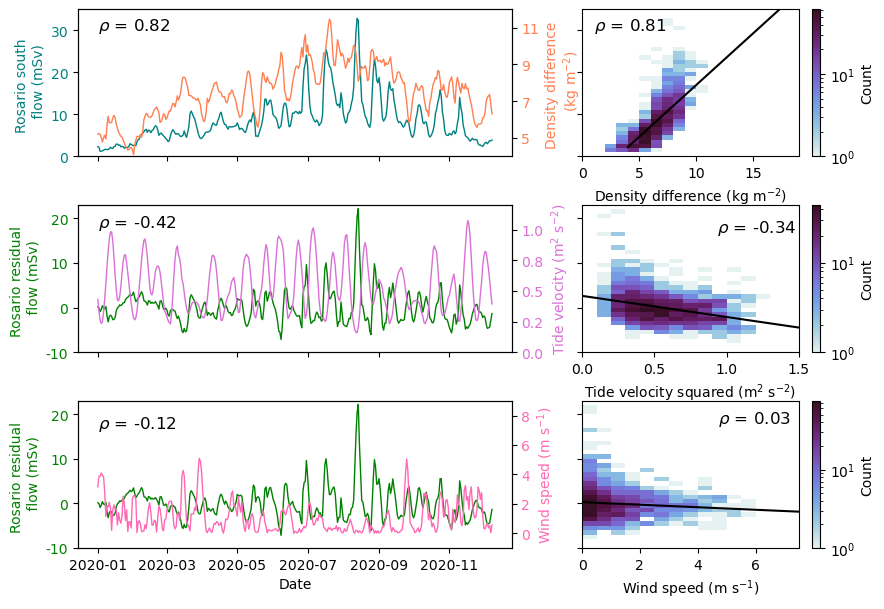

In [29]:
corr_ros2020_dd,p = stats.spearmanr(densdiff_ros2020,rostosouth_2020)
print(corr_ros2020_dd)
corr_ros_res2020,p = stats.spearmanr(tides_ros2020,res_ros2020)
print(corr_ros_res2020)
corr_ros_dd,p = stats.spearmanr(densdiff_ros,rostosouth[365:])
print(corr_ros_dd)
corr_ros_res,p = stats.spearmanr(tides_ros,res_ros)
print(corr_ros_res)
cmap = cm.dense

color1 = 'teal'
color2 = 'coral'
color3 = 'green'
color4 = 'orchid'

fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(10,7),gridspec_kw={'width_ratios':[1.6,1]})
ax1.plot(rostosouth_2020/1000,color=color1,lw=1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(datelist_rostosouth_2020,densdiff_ros2020,color=color2,lw=1)
ax1.set_ylim([0,35])
ax1.set_ylabel(f'Rosario south \n flow (mSv)',color=color1)
ax1.set_yticks(np.arange(0,35,10),color=color1)
ax1.set_yticklabels(np.arange(0,35,10),color=color1)
ax12.set_ylabel(f'Density difference \n (kg m$^{{-2}}$)',color=color2)
ax12.set_ylim([3,11])
ax12.set_yticklabels(np.arange(3,12,2),color=color2)
ax1.annotate(f'$\\rho$ = {np.round(corr_ros2020_dd,2)}',(datelist_rostosouth_2020.iloc[0],30),fontsize=12)

# ax2.scatter(densdiff_ros,rostosouth[365:],color='indigo')
# ax2.plot(densdiff_ros,ddline_ros,color='grey')
# ax2.set_yticks(np.arange(0,35000,5000))
# ax2.set_yticklabels([])
# ax2.set_xlabel('Density difference (kg/m3)')
# ax2.annotate(f'R$^2$ = {np.round(corr_ros_dd,2)}',(3.5,30000),fontsize=12)
arr,xe,ye,im = ax2.hist2d(densdiff_ros,rostosouth[365:]/1000,
                          bins=[np.arange(0,20,1),np.arange(0,38,1)],
                          norm=LogNorm(),
                          cmap=cmap
                                )
ax2.set_ylim([0,35])
ax2.set_yticks(np.arange(0,35,10))
ax2.set_yticklabels([])
cb = fig.colorbar(im, ax=ax2)
cb.set_label('Count')
ax2.plot(np.arange(4,20,0.5),ddline_ros_plot/1000,color='k')
ax2.annotate(f'$\\rho$ = {np.round(corr_ros_dd,2)}',(1,30),fontsize=12)
ax2.set_xlabel(f'Density difference (kg m$^{{-2}}$)')

ax3.plot(res_ros2020/1000,color='green',zorder=0,lw=1)
ax32 = ax3.twinx()
ax32.plot(datelist_rostosouth_2020,tides_ros2020,color='orchid',lw=1)
ax3.set_ylim([-10,23])
ax5.set_xlabel('Date')
ax3.set_ylabel(f'Rosario residual \n flow (mSv)',color=color3)
ax32.set_ylabel(f'Tide velocity (m$^2$ s$^{{-2}}$)',color=color4)
ax3.set_yticks(np.arange(-10,23,10),color=color3)
ax3.set_yticklabels(np.arange(-10,23,10),color=color3)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'$\\rho$ = {np.round(corr_ros_res2020,2)}',(datelist_rostosouth_2020.iloc[0],18),fontsize=12)
ax3.set_xticklabels([])

arr,xe,ye,im = ax4.hist2d(tides_ros,res_ros/1000,
                          bins=[np.arange(0,1.6,0.1),np.arange(-10,23,1)],
                          norm=LogNorm(),
                          cmap=cmap
                                )
# ax4.scatter(tides_ros,res_ros,color='indigo')
ax4.plot(np.arange(0,1.6,0.1),tline_ros_plot/1000,color='k')
cb = fig.colorbar(im, ax=ax4)
cb.set_label('Count')
ax4.set_ylim([-10,23])
ax3.set_yticks(np.arange(-10,23,10),color=color3)
ax4.set_yticklabels([])
ax4.set_xlabel(f'Tide velocity squared (m$^2$ s$^{{-2}}$)')
ax4.annotate(f'$\\rho$ = {np.round(corr_ros_res,2)}',(0.93,17),fontsize=12)

fig.subplots_adjust(wspace=0.2,hspace=0.33);

ax5.plot(datelist_rostosouth_2020,res_ros2020/1000,color='green',lw=1)
ax5.set_ylim([-10,23])
ax5.set_ylabel(f'Rosario residual \n flow (mSv)',color=color3)
ax5.set_yticks(np.arange(-10,23,10),color=color3)
ax5.set_yticklabels(np.arange(-10,23,10),color=color3)
ax52 = ax5.twinx()
ax52.plot(datelist_rostosouth_2020,np.abs(winds_ros2020),color='hotpink',lw=1)
ax52.set_ylim([-1,9])
ax52.set_yticks(np.arange(0,9,2),color='hotpink')
ax52.set_yticklabels(np.arange(0,9,2),color='hotpink')
ax52.set_ylabel(f'Wind speed (m s$^{{-1}}$)',color='hotpink')
ax5.annotate(f'$\\rho$ = {np.round(corr_winds_resros2020,2)}',(datelist_rostosouth_2020.iloc[0],17),fontsize=12)

arr,xe,ye,im = ax6.hist2d(np.abs(winds_ros),res_ros/1000,
                          bins=[np.arange(0,8,0.5),np.arange(-10,23,1)],
                          norm=LogNorm(),
                          cmap=cmap
                                )
# ax6.scatter(np.abs(winds_ros),res_ros,color='indigo')
ax6.plot(np.arange(0,10,0.5),wline_ros_plot/1000,color='k')
ax6.set_ylim([-10,23])
ax6.set_yticks(np.arange(-10,23,10),color=color3)
ax6.set_yticklabels([])
ax6.set_xlabel(f'Wind speed (m s$^{{-1}}$)')
ax6.annotate(f'$\\rho$ = {np.round(corr_winds_resros,2)}',(4.7,18),fontsize=12);
cb = fig.colorbar(im, ax=ax6)
cb.set_label('Count')


In [30]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/ros_south_correlations_2dhist.png',bbox_inches='tight')

In [31]:
corr_ros_tide_2018_sum,p = stats.spearmanr(tides_ros2018[150:270],res_ros2018[150:270])
corr_ros_tide_2019_sum,p = stats.spearmanr(tides_ros2019[130:250],res_ros2019[130:250])
corr_ros_tide_2020_sum,p = stats.spearmanr(tides_ros2020[150:270],res_ros2020[150:270])
corr_ros_tide_2021_sum,p = stats.spearmanr(tides_ros2021[130:250],res_ros2021[130:250])

print(stats.spearmanr(tides_ros2018,res_ros2018)[0])
print(corr_ros_tide_2018_sum)
print(stats.spearmanr(tides_ros2019,res_ros2019)[0])
print(corr_ros_tide_2019_sum)
print(stats.spearmanr(tides_ros2020,res_ros2020)[0])
print(corr_ros_tide_2020_sum)
print(stats.spearmanr(tides_ros2021,res_ros2021)[0])
print(corr_ros_tide_2021_sum)

print('Average of all May - Sept:',np.mean([corr_ros_tide_2018_sum,corr_ros_tide_2019_sum,corr_ros_tide_2020_sum,corr_ros_tide_2021_sum]))

-0.31841410915150675
-0.3445100354191263
-0.39063466435987676
-0.5419404125286477
-0.42143089094354297
-0.5717063684978122
-0.22270650240376666
-0.5011528578373496
Average of all May - Sept: -0.4898274185707339


In [32]:
mask = np.isin(datelist_winds,date_haro_bclin)
winds_haro_bclin = y_mean4[mask]

mask = np.isin(datelist_dens,date_haro_bclin)
densdiff_haro_bclin = dens_diff_vspr[mask]
date_dens_haro_bclin = np.array(datelist_dens)[mask]

slope,intercept = np.polyfit(densdiff_haro_bclin,haro_bclin,1)
ddline_haro_bclin = slope*densdiff_haro_bclin+intercept
res_haro_bclin = haro_bclin - ddline_haro_bclin

mask = np.isin(datelist_tides,date_haro_bclin)
tides_haro_bclin = tides[mask]
date_tides_haro_bclin = np.array(datelist_tides)[mask]

corr_res_haro_bclin_tides,p = stats.spearmanr(tides_haro_bclin,res_haro_bclin)
print(corr)

slope,intercept = np.polyfit(np.abs(winds_haro_bclin),res_haro_bclin,1)
w_line_harobclin = slope*winds_haro_bclin+intercept

0.15398827634763732


### Winds and baroclinic haro

In [33]:
res_haro_bclin2018

mask = np.isin(datelist_winds,date_haro2018)
winds_haro2018 = y_mean4[mask]
corr_wind_resharo2018,p = stats.spearmanr(np.abs(winds_haro2018),res_haro_bclin2018)
print(corr_wind_resharo2018)

#2019
mask = np.isin(datelist_winds,date_haro2019)
winds_haro2019 = y_mean4[mask]
corr_wind_resharo2019,p = stats.spearmanr(np.abs(winds_haro2019),res_haro_bclin2019)
print(corr_wind_resharo2019)

#2020
mask = np.isin(datelist_winds,date_haro2020)
winds_haro2020 = y_mean4[mask]
corr_wind_resharo2020,p = stats.spearmanr(np.abs(winds_haro2020),res_haro_bclin2020)
print(corr_wind_resharo2020)

#2021
mask = np.isin(datelist_winds,date_haro2021)
winds_haro2021 = y_mean4[mask]
corr_wind_resharo2021,p = stats.spearmanr(np.abs(winds_haro2021),res_haro_bclin2021)
print(corr_wind_resharo2021)

slope,intercept = np.polyfit(tides_haro_bclin2018,res_haro_bclin2018,1)
tline_haro2018 = slope*tides_haro_bclin2018+intercept
res2_haro_bclin2018 = res_haro_bclin2018.values - tline_haro2018.values
corr,p = stats.spearmanr(np.abs(winds_haro2018),res2_haro_bclin2018)
print('Res2:',corr)

slope,intercept = np.polyfit(tides_haro_bclin2019,res_haro_bclin2019,1)
tline_haro2019 = slope*tides_haro_bclin2019+intercept
res2_haro_bclin2019 = res_haro_bclin2019.values - tline_haro2019.values
corr,p = stats.spearmanr(np.abs(winds_haro2019),res2_haro_bclin2019)
print(corr)

slope,intercept = np.polyfit(tides_haro_bclin2020,res_haro_bclin2020,1)
tline_haro2020 = slope*tides_haro_bclin2020+intercept
res2_haro_bclin2020 = res_haro_bclin2020.values - tline_haro2020.values
corr,p = stats.spearmanr(np.abs(winds_haro2020),res2_haro_bclin2020)
print(corr)

slope,intercept = np.polyfit(tides_haro_bclin2021,res_haro_bclin2021,1)
tline_haro2021 = slope*tides_haro_bclin2021+intercept
res2_haro_bclin2021 = res_haro_bclin2021.values - tline_haro2021.values
corr,p = stats.spearmanr(np.abs(winds_haro2021),res2_haro_bclin2021)
print(corr)

-0.13279163138138664
-0.10278339067290906
0.04892639568560871
-0.09085926897653054
Res2: -0.2063169899581509
-0.09321670617704611
-0.12755115319781254
-0.1432891914513269


In [34]:
corr_btrop_tides_2020,p = stats.spearmanr(tides_haro_btrop2020,haro_btrop2020)
print(corr_btrop_tides_2020)

corr_btrop_dd_2020,p = stats.spearmanr(densdiff_haro_btrop2020,haro_btrop2020.dropna())
print(corr_btrop_dd_2020)

corr_winds_harobtrop_2020,p = stats.spearmanr(np.abs(winds_haro2020),haro_btrop2020)
print(corr_winds_harobtrop_2020)

corr_winds_harobtrop,p = stats.spearmanr(np.abs(winds_harobtrop),haro_btrop)
print(corr_winds_harobtrop)

slope,intercept = np.polyfit(tides_haro_btrop,haro_btrop,1)
line_btrop_tides = slope*tides_haro_btrop+intercept
line_btrop_tides_plot = slope*np.arange(0,1.8,0.08) + intercept

slope,intercept = np.polyfit(densdiff_haro_btrop,haro_btrop,1)
line_btrop_dd = slope*densdiff_haro_btrop+intercept
line_btrop_dd_plot = slope*np.arange(0,20,0.5) + intercept

-0.3726395080334958
0.17243553077968338
0.012309149620644678
-0.10807843577702732


### Baroclinic haro correlations

In [35]:
res_haro_bclin_4d = res_haro_bclin.rolling(4, center=True).mean()

slope,intercept = np.polyfit(tides_haro_bclin,res_haro_bclin,1)
line_res_tides = slope*tides_haro_bclin+intercept
line_res_tides_plot = np.arange(0,1.8,0.08)*slope+intercept

slope,intercept = np.polyfit(densdiff_haro_bclin,haro_bclin,1)
line_bclin_dd = slope*densdiff_haro_bclin+intercept
line_bclin_dd_plot = slope*np.arange(0,20,0.5)+intercept

In [36]:
# Calculate all correlations

corr_tides_resbclin_2018,p = stats.spearmanr(tides_haro_bclin2018,res_haro_bclin2018)
print('Tides:',corr_tides_resbclin_2018)
corr_tides_resbclin_2019,p = stats.spearmanr(tides_haro_bclin2019,res_haro_bclin2019)
print(corr_tides_resbclin_2019)
corr_tides_resbclin_2020,p = stats.spearmanr(tides_haro_bclin2020,res_haro_bclin2020)
print(corr_tides_resbclin_2020)
corr_tides_resbclin_2021,p = stats.spearmanr(tides_haro_bclin2021,res_haro_bclin2021)
print(corr_tides_resbclin_2021)

Tides: -0.7082959095514824
-0.7651548168545333
-0.7396169827708827
-0.7204493553050683


###  2-d histogram

In [37]:
print('Correlations for all yrs')
corr_tides_res,p = stats.spearmanr(tides_haro_bclin,res_haro_bclin.dropna())
print('Tides and residual haro bclin:',corr_tides_res)

corr_bclin_dd,p = stats.spearmanr(densdiff_haro_bclin,haro_bclin.dropna())
print('DD and haro bclin:',corr_bclin_dd)

print('Correlations in 2020')
corr_tides_res_2020,p = stats.spearmanr(tides_haro_bclin2020,res_haro_bclin2020.dropna())
print('Tides and residual haro bclin:',corr_tides_res_2020)

corr_bclin_dd_2020,p = stats.spearmanr(densdiff_haro_bclin2020,haro_bclin2020.dropna())
print('DD and haro bclin:',corr_bclin_dd_2020)

Correlations for all yrs
Tides and residual haro bclin: -0.725374736921202
DD and haro bclin: 0.7340249189439314
Correlations in 2020
Tides and residual haro bclin: -0.7396169827708827
DD and haro bclin: 0.6793202170511669


In [38]:
stats.spearmanr(np.abs(winds_haro_bclin),res_haro_bclin)

SignificanceResult(statistic=-0.06893125523507629, pvalue=0.008353240464617875)

In [39]:
stats.spearmanr(winds_haro_bclin,res_haro_bclin)

SignificanceResult(statistic=0.017559129699412906, pvalue=0.5021568040699751)

/tmp/ipykernel_2781446/2017972505.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax12.set_yticklabels(np.arange(3,12,2),color=color2)
/tmp/ipykernel_2781446/2017972505.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)


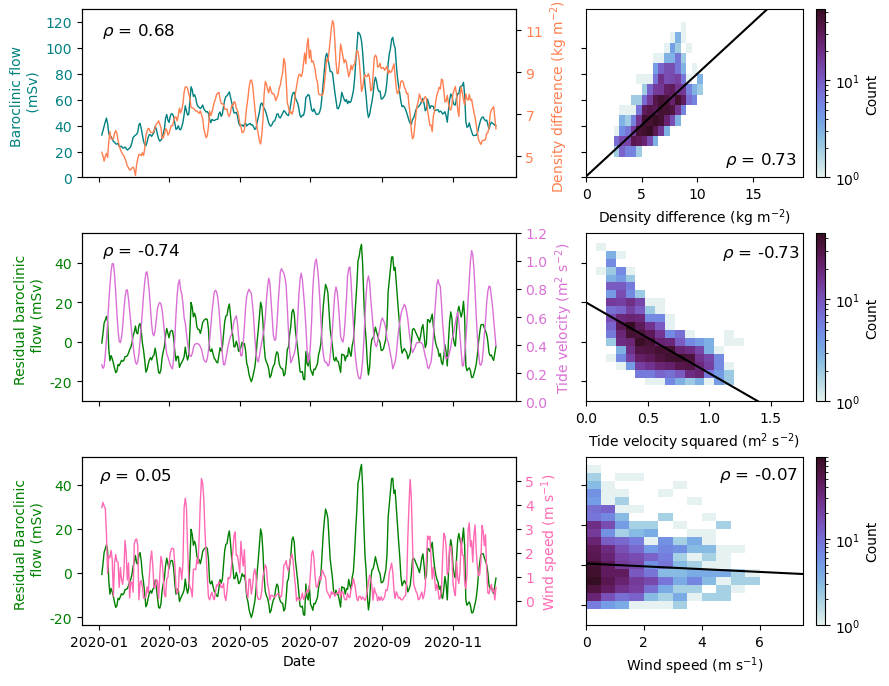

In [40]:
corr_winds_resharo,p = stats.spearmanr(np.abs(winds_haro_bclin),res_haro_bclin)

slope,intercept = np.polyfit(np.abs(winds_haro_bclin),res_haro_bclin,1)
w_line_harobclin = slope*winds_haro_bclin+intercept
w_line_harobclin_plot = slope*np.arange(0,8,0.5)+intercept

fig,[[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2,figsize=(10,8),gridspec_kw={'width_ratios':[1.6,1]})

ax1.plot(haro_bclin2020/1000,color=color1,lw=1)
ax1.set_xticklabels([])
ax12 = ax1.twinx()
ax12.plot(date_haro2020,densdiff_haro_bclin2020,color=color2,lw=1)
ax1.set_ylim([0,130])
ax1.set_ylabel(f'Baroclinic flow \n (mSv)',color=color1)
ax1.set_yticks(np.arange(0,121,20),color=color1)
ax1.set_yticklabels(np.arange(0,121,20),color=color1)
ax12.set_ylabel(f'Density difference (kg m$^{{-2}}$))',color=color2)
ax12.set_ylim([3,11])
ax12.set_yticklabels(np.arange(3,12,2),color=color2)
ax1.annotate(f'$\\rho$ = {np.round(corr_bclin_dd_2020,2)}',(date_haro2020[0],110),fontsize=12)

arr,xe,ye,im = ax2.hist2d(densdiff_haro_bclin,haro_bclin/1000,
                          bins=[np.arange(0,20,0.5),np.arange(0,130,8)],
                          norm=LogNorm(),
                          cmap=cmap
                                )
# ax2.scatter(densdiff_haro_bclin,haro_bclin,color='indigo')
ax2.plot(np.arange(0,20,0.5),line_bclin_dd_plot/1000,color='k')
ax2.set_ylim([0,130])
ax2.set_yticks(np.arange(0,120,20),color=color1)
ax2.set_yticklabels([])
ax2.set_xlabel(f'Density difference (kg m$^{{-2}}$)')
cb = fig.colorbar(im,ax=ax2)
cb.set_label('Count')
ax2.annotate(f'$\\rho$ = {np.round(corr_bclin_dd,2)}',(12.5,10),fontsize=12)

ax3.plot(res_haro_bclin2020/1000,color=color3,lw=1)
ax32 = ax3.twinx()
ax32.plot(date_haro2020,tides_haro_bclin2020,color=color4,lw=1)
ax3.set_ylim([-30,55])

ax3.set_ylabel(f'Residual baroclinic \n flow (mSv)',color=color3)
ax32.set_ylabel(f'Tide velocity (m$^2$ s$^{{-2}}$)',color=color4)
ax3.set_yticks(np.arange(-20,41,20),color=color3)
ax3.set_yticklabels(np.arange(-20,41,20),color=color3)
# ax3.set_yticklabels(np.arange(-25000,46000,15000),color=color3)
ax32.set_ylim([0,1.2])
ax32.set_yticklabels(np.arange(0,1.2,0.2),color=color4)
ax32.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.annotate(f'$\\rho$ = {np.round(corr_tides_res_2020,2)}',(date_haro2020[0],44),fontsize=12)
ax3.set_xticklabels([])

arr,xe,ye,im = ax4.hist2d(tides_haro_bclin,res_haro_bclin.dropna()/1000,
                          bins=[np.arange(0,1.8,0.08),np.arange(-30,55,4)],
                          norm=LogNorm(),
                          cmap=cmap
                                )
# ax4.scatter(tides_haro_bclin,res_haro_bclin.dropna(),color='indigo')
ax4.plot(np.arange(0,1.8,0.08),line_res_tides_plot/1000,color='k')
ax4.set_ylim([-30,55])
ax3.set_yticks(np.arange(-20,41,20),color=color3)
ax4.set_yticklabels([])
ax4.set_xlabel(f'Tide velocity squared (m$^2$ s$^{{-2}}$)')
ax4.annotate(f'$\\rho$ = {np.round(corr_tides_res,2)}',(1.1,43),fontsize=12)
cb = fig.colorbar(im,ax=ax4)
cb.set_label('Count')

fig.subplots_adjust(wspace=0.2,hspace=0.33)

ax5.plot(date_haro2020,res_haro_bclin2020/1000,color='green',lw=1)
ax5.set_ylabel(f'Residual Baroclinic \n flow (mSv)',color=color3)
ax6.set_ylim([-30,55])
ax5.set_yticks(np.arange(-20,41,20),color=color3)
ax5.set_yticklabels(np.arange(-20,41,20),color=color3)
# ax5.set_yticklabels(np.arange(-20000,45000,20000),color=color3)
ax52 = ax5.twinx()
ax52.plot(date_haro2020,np.abs(winds_haro2020),color='hotpink',lw=1)
ax52.set_ylim([-1,6])
ax52.set_yticks(np.arange(0,6,1),color='hotpink')
ax52.set_yticklabels(np.arange(0,6,1),color='hotpink')
ax52.set_ylabel(f'Wind speed (m s$^{{-1}}$)' ,color='hotpink')
ax5.annotate(f'$\\rho$ = {np.round(corr_wind_resharo2020,2)}',(datelist_rostosouth_2020.iloc[0],42),fontsize=12)
ax5.set_xlabel('Date')

arr,xe,ye,im = ax6.hist2d(np.abs(winds_haro_bclin),res_haro_bclin/1000,
                          bins=[np.arange(0,8,0.5),np.arange(-30,55,4)],
                          norm=LogNorm(),
                          cmap=cmap
                                )
# ax6.scatter(np.abs(winds_haro_bclin),res_haro_bclin,color='indigo')
ax6.plot(np.arange(0,8,0.5),w_line_harobclin_plot/1000,color='k')
ax6.set_yticks(np.arange(-20,41,20),color=color3)
ax6.set_yticklabels([])
ax6.set_xlabel(f'Wind speed (m s$^{{-1}}$)')
ax6.annotate(f'$\\rho$ = {np.round(corr_winds_resharo,2)}',(4.6,43),fontsize=12);
cb = fig.colorbar(im,ax=ax6)
cb.set_label('Count')

In [41]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/haro_bclin_correlations_2dhist.jpg',bbox_inches='tight')

## Components of south flow

In [43]:
density_adm = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_admpr.csv')
dens_diff_adm = np.array(density_adm.south - density_adm.north)
density_adm = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_admpr_v3.csv')
dens_diff_adm = np.array(density_adm.north - density_adm.south)
density_vspr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_vspr_v4.csv')
dens_diff_vspr = np.array(density_vspr.north - density_vspr.south)

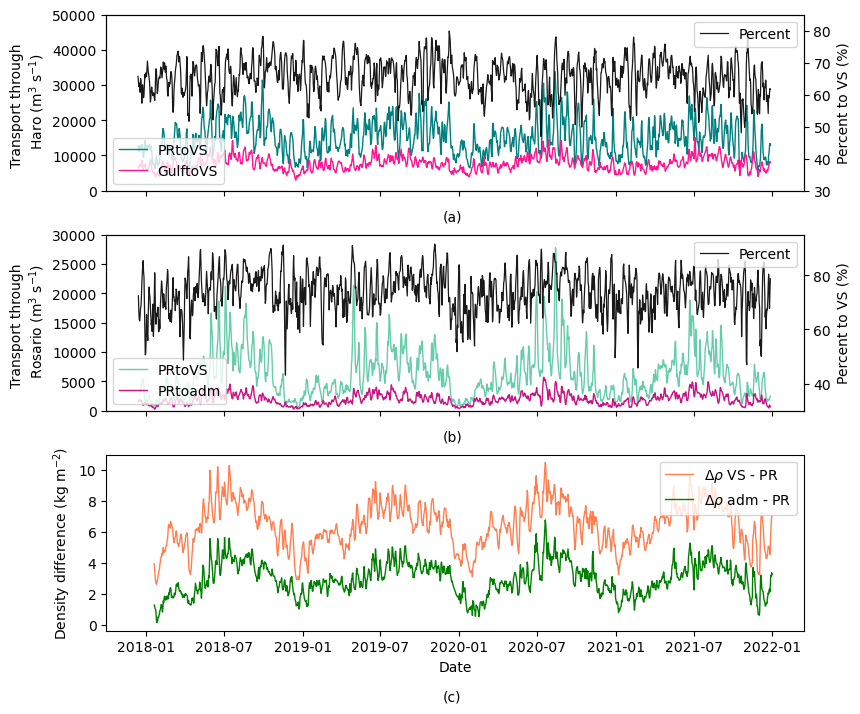

In [44]:
prop_vs_haro = prtovs_haro_avg /(prtovs_haro_avg+Gulftovs_haro_avg)*100
prop_vs_ros = prtovs_ros_avg / (prtovs_ros_avg + prtoadm_ros_avg)*100

fig,[ax,ax3,ax5] = plt.subplots(3,1,figsize=(9,8),sharex=True)

ax.plot(prtovs_haro_avg,color='teal',lw=1,label='PRtoVS')
ax.plot(Gulftovs_haro_avg,color='deeppink',lw=1,label='GulftoVS')
ax2 = ax.twinx()
ax2.plot(prop_vs_haro,color='k',lw=0.9,alpha=0.9,label='Percent')
ax2.set_ylim([30,85])
ax.set_ylabel(f'Transport through \n Haro (m$^3$ s$^{{-1}}$)')
ax.set_ylim([0,50000])
ax.legend(loc=3)
# ax2.legend(loc=3)
ax2.set_ylabel('Percent to VS (%)')
ax2.legend(loc=1)

ax3.plot(prtovs_ros_avg[365:],lw=1,color='mediumaquamarine',label='PRtoVS')
ax3.plot(prtoadm_ros_avg[365:],lw=1,color='mediumvioletred',label='PRtoadm')
ax4 = ax3.twinx()
ax4.plot(prop_vs_ros[365:],color='k',lw=0.9,alpha=0.9,label='Percent')
ax3.set_ylabel('Transport through \n Rosario (m$^3$ s$^{{-1}}$)')
ax4.set_ylim([30,95])
ax3.set_ylim([0,30000])
ax3.legend(loc=3)
ax4.set_ylabel('Percent to VS (%)')
ax4.legend(loc=1)

ax5.plot(datelist_dens[750:-365],dens_diff_vspr[750:-365],lw=1,color='coral',label='$\\Delta \\rho$ VS - PR')
# ax6 = ax5.twinx()
ax5.plot(datelist_dens[750:-365],dens_diff_adm[750:-365],color='green',lw=1,label='$\\Delta \\rho$ adm - PR')
# ax6.plot(datelist_dens[750:-365],dens_diff_vspr[750:-365]-dens_diff_adm[750:-365],lw=1,color='k')
ax5.set_xlabel('Date')
# ax5.set_ylim([2,16])
# ax6.set_ylim(50,60)
ax5.legend(loc=1)
# ax6.legend(loc=2)
ax5.set_ylabel(f'Density difference (kg m$^{{-2}}$)')
ax6.set_ylabel(f'Density difference (kg m$^{{-2}}$)')

ax.text(0.483, -0.17, "(a)", transform=ax.transAxes)
ax3.text(0.483, -0.17, "(b)", transform=ax3.transAxes)
ax5.text(0.483, -0.40, "(c)", transform=ax5.transAxes)
fig.subplots_adjust(hspace=0.25)

In [45]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/components_south_flow.png',bbox_inches='tight')

In [46]:
dens_vspr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_vspr_v2.csv')
dens_vspr3 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_vspr_v3.csv')
dens_admpr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_admpr_v2.csv')
dens_admpr3 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_admpr_v3.csv')
dens_rospr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_rospr.csv')
dens_haropr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_haropr.csv')
dens_rospr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_rospr.csv')
dens_haropr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_haropr.csv')

dens_vspr_v4 = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_vspr_v4.csv')
dens_vs4 = dens_vspr_v4[365*2+1:365*6+2].north
dens_pr4 = dens_vspr_v4[365*2+1:365*6+2].south

dens_jdfpr = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_jdfpr.csv')
dens_jdf = dens_jdfpr[365*2+1:365*6+2].north
dens_pr_jdf = dens_jdfpr[365*2+1:365*6+2].south

dens_haroS = dens_haropr[365*2+1:365*6+2].north
dens_prH = dens_haropr[365*2+1:365*6+2].south
DD_haropr = dens_haroS-dens_prH

dens_rosS = dens_rospr[365*2+1:365*6+2].north
dens_prR = dens_rospr[365*2+1:365*6+2].south
DD_rospr = dens_rosS - dens_prR

DD_haroros = DD_haropr - DD_rospr


#Import upwelling data
upwelling = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/upwelling_index.csv').iloc[1:,:]
upwelling['time'] = pd.to_datetime(upwelling['time'])
df_avg = upwelling.groupby(pd.Grouper(key='time', freq='D')).mean().reset_index()
df_avg['4mean'] = df_avg.upwelling_index.rolling(window=4, center=True).mean()

upwl_date = df_avg.time.iloc[557:-2*365-182]
upwl_idx = df_avg['4mean'].iloc[557:-2*365-182]
upwl_date = [pd.to_datetime(date).tz_localize(None).to_pydatetime() for date in upwl_date]


/tmp/ipykernel_2781446/2368986953.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avg = upwelling.groupby(pd.Grouper(key='time', freq='D')).mean().reset_index()


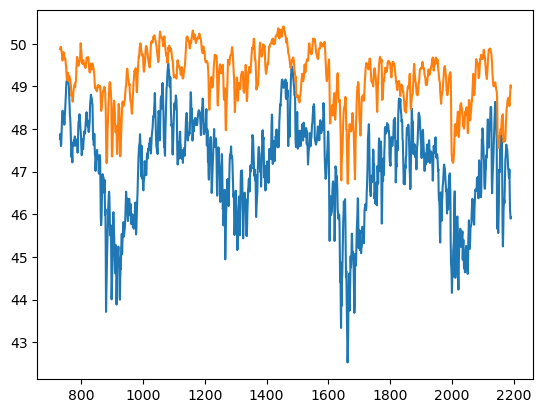

In [47]:
plt.plot(dens_prR)
plt.plot(dens_rosS)

In [48]:
dens_pr = dens_vspr[365*2+1:365*6+2].south
dens_vs = dens_vspr[365*2+1:365*6+2].north
dens_adm = dens_admpr[365*2+1:365*6+2].north

dens_pr3 = dens_vspr3[365*2+1:365*6+2].south
dens_vs3 = dens_vspr3[365*2+1:365*6+2].north
dens_adm3 = dens_admpr3[365*2+1:365*6+2].north
dens_haro3 = dens_admpr3[365*2+1:365*6+2].north
dens_ros = dens_rospr[365*2+1:365*6+2].north
dens_haro = dens_haropr[365*2+1:365*6+2].north

datelist = []

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2021,12,31)

while date <= enddate:
    datelist.append(date)
    date += dt.timedelta(days=1)

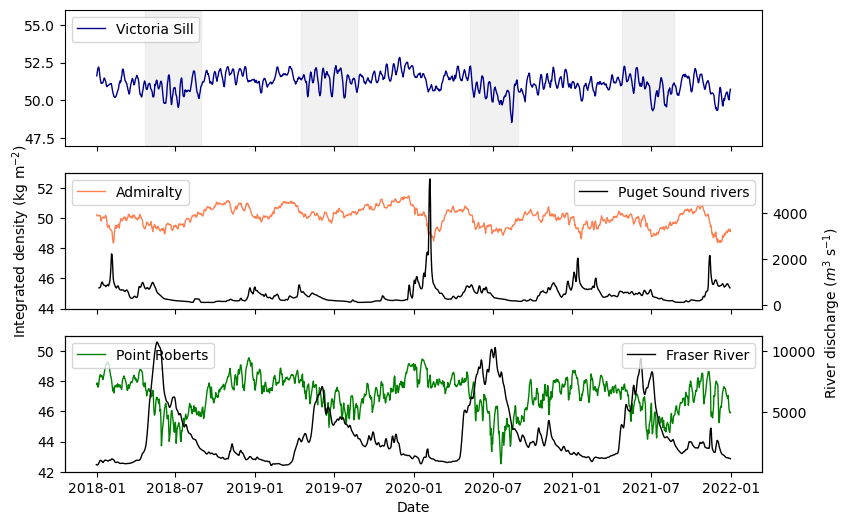

In [49]:
fig,[ax2,ax3,ax] = plt.subplots(3,1,figsize=(9,6),sharex=True)

ax.plot(datelist,dens_pr3,color='green',lw=1,label='Point Roberts')
ax2.plot(datelist,dens_vs3,color='darkblue',lw=1,label='Victoria Sill')
ax3.plot(datelist,dens_adm3,color='coral',lw=1,label='Admiralty')
ax.legend(loc=2)
ax2.legend(loc=2)
ax3.legend(loc=2)

ax02 = ax.twinx()
ax02.plot(datelist_FR[365*2:-365],FR_4mean[365*2:-365],color='k',lw=1,label='Fraser River')

ax32 = ax3.twinx()
ax32.plot(pugetr_m3s[25:-365],color='k',lw=1,label='Puget Sound rivers')

ax02.legend(loc=1)
ax32.legend(loc=1)


ax3.set_ylabel(f'Integrated density (kg m$^{{-2}}$)')
ax.set_xlabel('Date')
ax02.set_ylabel(f'                                         River discharge ($m^3$ s$^{{-1}}$)')


ax2.set_ylim(47,56)
# ax2.set_ylim(78,86)
ax3.set_ylim(44,53)
ax.set_ylim(42,51)
# ax2.set_yticks(np.arange(47,56,2));
ax3.set_yticks(np.arange(44,53,2));
ax.set_yticks(np.arange(42,51,2));

ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[110],x2=upwl_date[240],color='lightgrey', alpha=0.3)
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[470],x2=upwl_date[600],color='lightgrey', alpha=0.3)
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[860],x2=upwl_date[970],color='lightgrey', alpha=0.3)
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[1210],x2=upwl_date[1330],color='lightgrey', alpha=0.3)

### Combine

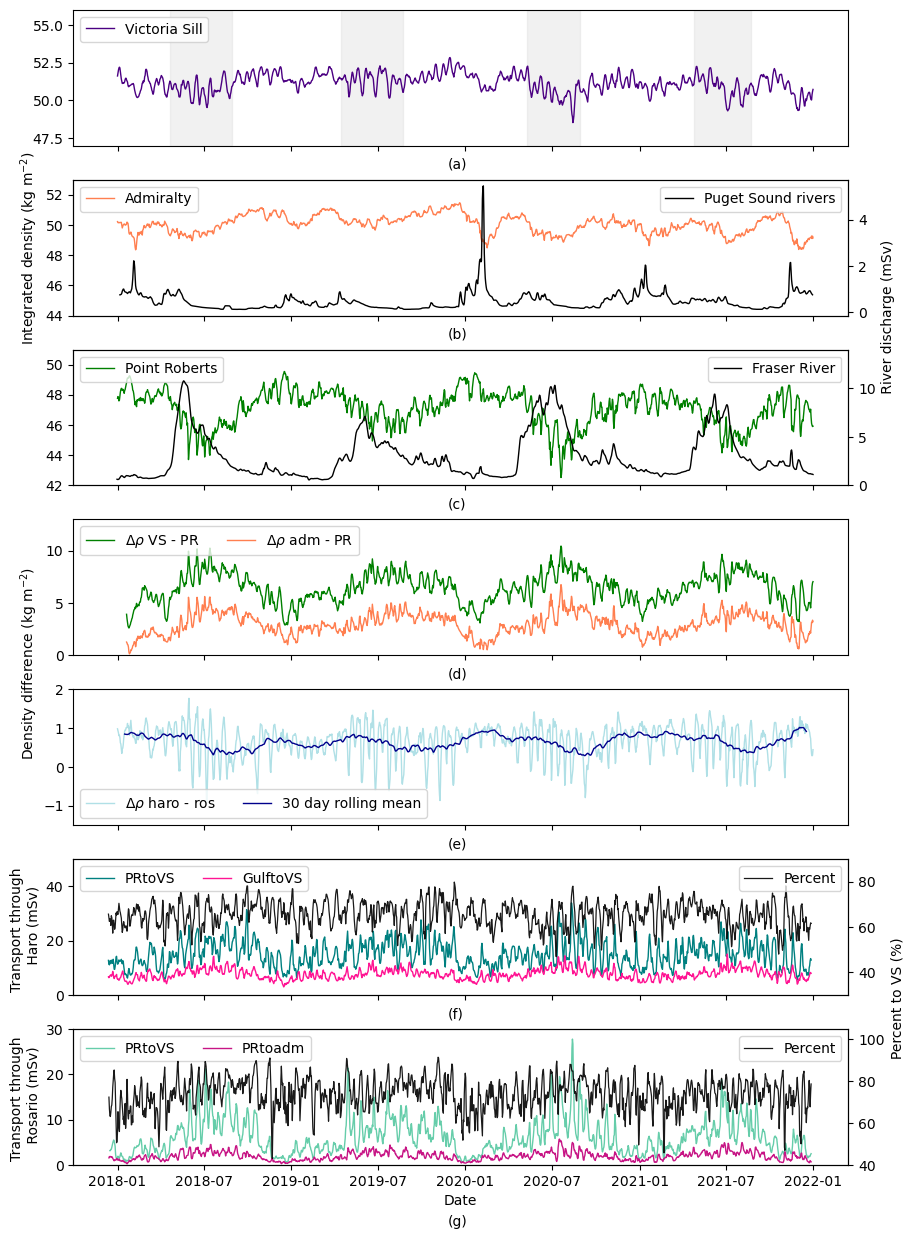

In [52]:
DD_haroros_rollmean = DD_haroros.rolling(30, center=True).mean()

fig,[ax2,ax3,ax,ax12,ax13,ax10,ax11] = plt.subplots(7,1,figsize=(10,15),sharex=True)

#############
#Density
#############

ax.plot(datelist,dens_pr3,color='green',lw=1,label='Point Roberts')
ax2.plot(datelist,dens_vs3,color='indigo',lw=1,label='Victoria Sill')
ax3.plot(datelist,dens_adm3,color='coral',lw=1,label='Admiralty')
ax.legend(loc=2)
ax2.legend(loc=2)
ax3.legend(loc=2)

ax02 = ax.twinx()
ax02.plot(datelist_FR[365*2:-365],FR_4mean[365*2:-365]/1000,color='k',lw=1,label='Fraser River')
ax02.set_ylim(0,14000/1000)

ax32 = ax3.twinx()
ax32.plot(pugetr_m3s[25:-365]/1000,color='k',lw=1,label='Puget Sound rivers')

ax02.legend(loc=1)
ax32.legend(loc=1)


ax3.set_ylabel(f'Integrated density (kg m$^{{-2}}$)')
# ax.set_xlabel('Date')
ax02.set_ylabel(f'                                              River discharge (mSv)')


ax2.set_ylim(47,56)
# ax2.set_ylim(78,86)
ax3.set_ylim(44,53)
ax.set_ylim(42,51)
# ax2.set_yticks(np.arange(47,56,2));
ax3.set_yticks(np.arange(44,53,2));
ax.set_yticks(np.arange(42,51,2));

ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[110],x2=upwl_date[240],color='lightgrey', alpha=0.3)
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[470],x2=upwl_date[600],color='lightgrey', alpha=0.3)
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[860],x2=upwl_date[970],color='lightgrey', alpha=0.3)
ax2.fill_betweenx(y=np.linspace(ax2.get_ylim()[0], ax2.get_ylim()[1], 100),x1=upwl_date[1210],x2=upwl_date[1330],color='lightgrey', alpha=0.3)


##############
#Proportions
##############


ax10.plot(prtovs_haro_avg/1000,color='teal',lw=1,label='PRtoVS')
ax10.plot(Gulftovs_haro_avg/1000,color='deeppink',lw=1,label='GulftoVS')
ax102 = ax10.twinx()
ax102.plot(prop_vs_haro,color='k',lw=0.9,alpha=0.9,label='Percent')
ax102.set_ylim([30,90])
ax10.set_ylabel(f'Transport through \n Haro (mSv)')
ax10.set_ylim([0,50])
ax10.legend(loc=2,ncol=2)
# ax2.legend(loc=3)
# ax102.set_ylabel('Percent to VS (%)')
ax102.legend(loc=1)

ax11.plot(prtovs_ros_avg[365:]/1000,lw=1,color='mediumaquamarine',label='PRtoVS')
ax11.plot(prtoadm_ros_avg[365:]/1000,lw=1,color='mediumvioletred',label='PRtoadm')
ax112 = ax11.twinx()
ax112.plot(prop_vs_ros[365:],color='k',lw=0.9,alpha=0.9,label='Percent')
ax11.set_ylabel('Transport through \n Rosario (mSv)')
ax112.set_ylim([40,105])
ax112.set_yticks(np.linspace(40,100,4))
ax11.set_ylim([0,30])
ax11.legend(loc=2,ncol=2)
# ax11.legend(ncol=2,bbox_to_anchor=(0.3, 1.05))
ax112.set_ylabel('                                             Percent to VS (%)')
ax112.legend(loc=1)


ax12.plot(datelist_dens[750:-365],dens_diff_vspr[750:-365],lw=1,color='green',label='$\\Delta \\rho$ VS - PR')
ax12.plot(datelist_dens[750:-365],dens_diff_adm[750:-365],color='coral',lw=1,label='$\\Delta \\rho$ adm - PR')
ax11.set_xlabel('Date')
ax12.legend(loc=2,ncol=2)
ax12.set_ylabel(f'Density difference (kg m$^{{-2}}$)                                   ')
ax12.set_ylim(0,13)

ax13.plot(datelist,DD_haroros,lw=1,color='powderblue',label='$\\Delta \\rho$ haro - ros')
ax13.plot(datelist_dens[731:-365],DD_haroros_rollmean,lw=1,color='darkblue',label='30 day rolling mean')
ax13.legend(loc=3,ncol=2)
ax13.set_ylim(-1.5,2)

ax10.text(0.483, -0.17, "(f)", transform=ax10.transAxes)
ax11.text(0.483, -0.45, "(g)", transform=ax11.transAxes)
ax12.text(0.483, -0.17, "(d)", transform=ax12.transAxes)
ax13.text(0.483, -0.17, "(e)", transform=ax13.transAxes)
ax2.text(0.483, -0.17, "(a)", transform=ax2.transAxes)
ax3.text(0.483, -0.17, "(b)", transform=ax3.transAxes)
ax.text(0.483, -0.17, "(c)", transform=ax.transAxes)
fig.subplots_adjust(hspace=0.25)

In [53]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/density_and_comp_southflow.jpg',bbox_inches='tight')

#### Correlations for density comparisons

##### Rosario Strait

In [55]:
stats.spearmanr(rostosouth,dens_diff_vspr[350:-369])

SignificanceResult(statistic=0.8150783666908216, pvalue=0.0)

In [56]:
stats.spearmanr(rostosouth,dens_diff_adm[350:-369])

SignificanceResult(statistic=0.7689704111268196, pvalue=0.0)

##### Haro Strait

In [57]:
stats.spearmanr(harotosouth,densdiff_haro)

SignificanceResult(statistic=0.7512916597511109, pvalue=2.63371676597627e-268)

In [58]:
mask = np.isin(datelist_dens,date_harosh)
densdiff_haro_adm = dens_diff_adm[mask]

stats.spearmanr(harotosouth,densdiff_haro_adm)

SignificanceResult(statistic=0.7399788796827642, pvalue=3.8942438590972393e-256)